# An analysis of MBTI types using NLP techniques
#### Advanced Data Science - NLP Exam Project

*Emanuele Lena*



## Introduction 

### Project goals and methods

The purpose of this project is to analyze the descriptions of the **Myers-Briggs Type Indicator (MBTI) 16 psychological types** using *Natural Language Processing (NLP)* and data science techniques.

The actual goals of the project are two:

1. first, we want to see if NPL techniques can be used to extract information, traits and similarities between the types;

2. secondly, we want to see if in the overall description of the types there is some kind of emergent structure, and if this structure follows the proposed MBTI dichotomies or not.

Used methods include:

- sentence scoring-based summarization (frequency and TF-IDF);
- clustering on TF-IDF vectors using K-Means
- PCA
- POS tagging and clustering just on some parts of speech
- topic modelling using LDA

### The Myers-Briggs Type Indicator (MBTI)

Myers-Briggs Type Indicator (MBTI) is a self-report questionnaire that permits to classify people into 16 psychological types. The types are derived from Jung personality theory, and represent some sort of archetypes.

Types are defined by four dichotomies (pairs of opposite traits):

- **E**xtraversion (E) vs **I**ntroversion (I) $\leftarrow$ 
  - are you more internally or externally focused? 
  - Do you gain energy from being around people or from being alone?
- **S**ensing (S) vs i**N**tuition (N) $\leftarrow$ 
  - how do you gather information? 
  - Are you more practical and concrete or more abstract and theoretical?
- **T**hinking (T) vs **F**eeling (F) $\leftarrow$ 
  - how do you make decisions? 
  - Are you more rational (detached, reasonable, logical) or more emotional (empathetic, compassionate, sensitive, involved from inside)?
- **J**udging (J) vs **P**erceiving (P) $\leftarrow$ (a bit more tricky) 
  - it is a sort of lifestyle preference. 
  - Do you prefer to show externally your main perceiving function (sensing or intuition) or your main judging function (thinking or feeling)? 
  - are you (externally) more organized, methodical, scheduled, or more flexible, spontaneous, adaptable? 

$\Rightarrow$ combining those four dichotomies, you obtain 16 types, each one with a specific combination of traits. Each type is identified by four letters. Some examples:

> *"ENFP"* $\leftarrow$ Extraverted, iNtuitive, Feeler, who prefers do display his perceiving function (iNtuition).
> 
> *"ISTJ"* $\leftarrow$ Introverted, Sensor, Thinker, who prefers to display his judging function (Thinking).

Moreover, each type has been labelled with an "archetipal" name. For example, the ENFP type is called "The Campaigner", and the ISTJ type is called "The Logistician", etc.


### Further ideas and criticisms 

- there is a whole theory about the cognitive functions, differences between original Jung theory and MBTI, correlation with other indicators, etc.
- there is also a lot of criticism on validity and reliability of the test...
  - not all the theory is not based on scientific evidence
  - there is few evidence of the existence of some traits and some other traits seems not to be so dichotomous
  - results are not stable over time
  - "non predictive" nature of the test (it cannot predict future behaviour)
  - business and companies born around the test
  - etc.

Some sources:

- Wikipedia: https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator
- The 16 personalities descriptions and the main test website: https://www.16personalities.com/personality-types 

## All imports and settings

In [84]:
# all imports

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams 
from nltk.tag import pos_tag


import gensim
from collections import Counter, defaultdict
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from typing import List, Dict, Set, Tuple, Callable, Iterable
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import os


## The dataset

- Source: https://www.kaggle.com/datasets/yamaerenay/mbtitypes-full?select=types.csv 
  - (it contains the descriptions of the main website, grouped in a single CSV table)
- For each type, we have
  - the four letters dichotomy
  - the archetipal name (nickname)
  - various descriptions of different aspects of the type (e.g. "strengths", "weaknesses", "romantic relationships", etc.)

### Data gathering

You can download the CSV dataset from the [link above](https://www.kaggle.com/datasets/yamaerenay/mbtitypes-full?select=types.csv). To begin the analysis, extract eventual ZIPs and put the `types.csv` file it in the `./data/` folder.

In [85]:
types = pd.read_csv('data/types.csv')
types.set_index('Type', inplace=True)

In [86]:
types.head(3)

,Introduction,Strengths and Weaknesses,Romantic Relationships,Friendships,Parenthood,Career Paths,Workplace Habits,Conclusion,Celebrities,Description,Nickname,Definition,E,I,N,S,T,F,J,P
Type,,,,,,,,,,,,,,,,,,,,
INTJ,Introduction\n\nWHO IS AN ARCHITECT (INTJ)?\n\...,Strengths & Weaknesses\nArchitect (INTJ) Stren...,Romantic Relationships\n\n“Of all forms of cau...,Friendships\n\n“A friend to all is a friend to...,Parenthood\n\n“Children must be taught how to ...,Career Paths\n\n“One never notices what has be...,Workplace Habits\n\nWhat Architects (INTJs) wa...,Conclusion\n\n“No escape from patterns and sys...,"['Friedrich Nietzsche', 'Michelle Obama', 'Elo...","Imaginative and strategic thinkers, with a pla...",Architect,An Architect (INTJ) is a person with the Intro...,0,1,1,0,1,0,1,0
INTP,Introduction\n\nWHO IS A LOGICIAN (INTP)?\n\nA...,Strengths & Weaknesses\nLogician Strengths\nGr...,Romantic Relationships\n\nWhen it comes to rom...,Friendships\n\nMany of the usual motivations f...,"Parenthood\n\nIn parenting roles, as with many...","Career Paths\n\nLogicians are solitary, eccent...",Workplace Habits\n\nThe running theme for Logi...,Conclusion\n\nArmed with a powerful intellect ...,"['Bill Gates', 'Kristen Stewart', 'Albert Eins...",Innovative inventors with an unquenchable thir...,Logician,A Logician (INTP) is someone with the Introver...,0,1,1,0,1,0,0,1
ENTJ,Introduction\n\nWHO IS A COMMANDER (ENTJ)?\n\n...,Strengths & Weaknesses\nCommander Strengths\nE...,Romantic Relationships\n\nAs in other areas of...,Friendships\n\nAs in most aspects of their liv...,"Parenthood\n\nOften, given their strong will a...",Career Paths\n\nIt is in the world of careers ...,Workplace Habits\n\nFor people with the Comman...,Conclusion\n\nArmed with a powerful intellect ...,"['Steve Jobs', 'Gordon Ramsay', 'Margaret That...","Bold, imaginative and strong-willed leaders, a...",Commander,A Commander (ENTJ) is someone with the Extrave...,1,0,1,0,1,0,1,0


In [87]:
types.columns

Index(['Introduction', 'Strengths and Weaknesses', 'Romantic Relationships',
       'Friendships', 'Parenthood', 'Career Paths', 'Workplace Habits',
       'Conclusion', 'Celebrities', 'Description', 'Nickname', 'Definition',
       'E', 'I', 'N', 'S', 'T', 'F', 'J', 'P'],
      dtype='object')

We bring the data into two formats:

- format 1: a single Pandas `DataFrame`, with one row foreach type and single corpus column containing all the sections merged together
- format 2: a Pandas `DataFrame` with one row for each tuple `(type, section)` and a corpus column containing the text of the section

Before doing so, we make some corpus cleaning procedures (e.g., remove headlines in texts). We will discuss them later. 

In [88]:
# ---------------------------------------------------
# 0) Corpus cleaning

# columns to be used for corpus
corpus_cols = [
    'Description', 'Introduction', 'Strengths and Weaknesses',
    'Romantic Relationships', 'Friendships', 'Parenthood',
    'Career Paths', 'Workplace Habits', 'Conclusion'
]

for c in corpus_cols:

    # turn double "\n\n" into single "\n"
    types[c] = types[c].str.replace('\n\n', '\n')

    # remove from all corpus columns various headlines 
    lines = types[c].str.split('\n')
    
    # (the valid lines are the ones that has at least one ".")
    lines = lines.apply(lambda x: [l for l in x if '.' in l])

    types[c] = lines.str.join('\n')



In [89]:
# ------------------------------
# generate format 1: 

# generate a single description for each type
df_types_ft = pd.DataFrame()
df_types_ft['corpus'] = types.apply(
    lambda row: "\n".join(row[corpus_cols]), axis=1
    )

# get average nr. of words in each full-text corpus
print(
    "Average nr. of words in each full-text corpus:\t", 
    np.mean(df_types_ft['corpus'].apply(lambda x: len(x.split())))
    )

df_types_ft.head(5)

Average nr. of words in each full-text corpus:	 4047.25


,corpus
Type,
INTJ,"Imaginative and strategic thinkers, with a pla..."
INTP,Innovative inventors with an unquenchable thir...
ENTJ,"Bold, imaginative and strong-willed leaders, a..."
ENTP,Smart and curious thinkers who cannot resist a...
INFJ,"Quiet and mystical, yet very inspiring and tir..."


In [90]:
# generate format 2:
df_types_sects = types.reset_index() \
    .melt(  # turn columns into rows (identified by a 'Type','section' pair)
        id_vars='Type',
        value_vars=corpus_cols, 
        var_name='section', 
        value_name='corpus'
    )

df_types_sects.index = df_types_sects['Type'] + '.' + df_types_sects['section']

# get average nr. of words in each section corpus
print(
    "Average nr. of words in each section corpus:\t", 
    np.mean(df_types_sects['corpus'].apply(lambda x: len(x.split())))
    )

df_types_sects.head(5)

Average nr. of words in each section corpus:	 449.69444444444446


,Type,section,corpus
INTJ.Description,INTJ,Description,"Imaginative and strategic thinkers, with a pla..."
INTP.Description,INTP,Description,Innovative inventors with an unquenchable thir...
ENTJ.Description,ENTJ,Description,"Bold, imaginative and strong-willed leaders, a..."
ENTP.Description,ENTP,Description,Smart and curious thinkers who cannot resist a...
INFJ.Description,INFJ,Description,"Quiet and mystical, yet very inspiring and tir..."


## Summarization

### Goals (questions)

> Which are the main characteristics of each MBTI type? 
> How can we summarize them in few words?
> Which are their most discriminant traits?

**Tools and techniques**: *sencence scoring based summarization, TF-IDF*

### Proposed solution and work pipeline

**Proposed solution**: use sentence scoring summarization to extract the most important sentences foreach type. 

**Work pipeline**:

0. (some corpus cleaning we will see later)
1. preprocessing
    - to lowercase
    - tokenization
    - stopwords and punctuation removal
    - lemmatisation
    - n-gram generation (words + bi-grams)
2. generation of a frequency dictionary (which tracks the occorrences and the frequencies of each word in all documents)
3. token scoring
4. using token scoring to score sentences
5. select sentences according to some criteria (e.g., treshold)

### Alternative choices and issues

**Alternative choices**:

- use the whole corpus (of each type) as an unique text VS use the sections as separated texts 
  - first solution brings to a more "general" summary foreach type
  - second solution brings to more "specific" summaries foreach section of each type
- use a simple frequency-based scoring VS use a TF-IDF scoring (where documents are types/types-sections)
  - second solution may bring to a more "discriminant" summary, but it may miss some still relevant but not discriminant sentences

**Found issues**:

- corpus is full of non useful headlines
  - (if not treated, they may receive a high score because they usually contain the type name, which is usually the most frequent word in the corpus...)
  - *SOLUTION*: remove headlines from the corpus 
    - we detect them as lines withouth dots
    - we do that in a corpus cleaning step, before the preprocessing
- types sentences scores may have very different distributions (centered around different values, more or less wide, etc.) $\Rightarrow$ it may be difficult to find a good treshold for all types
  - to uniform scores ranges, we always use a local min-max normalization (we normalize scores foreach type)
  - we see later how to deal this issue

In [91]:
# ------------------------------
# 1) preprocessing: 
#   define a preprocessing function 
#   and some other useful tools

# generate lemmatizer
lemmatizer = WordNetLemmatizer()

# extract types letters, nicknames and their plural forms
# (we will need them later)
types_letters_and_nicknames = [w.lower() for w in list(types.Nickname) + list(types.index)]
types_letters_and_nicknames += [w + 's' for w in types_letters_and_nicknames]

def preprocessing(
        text: str, 
        n_ngrams: int = 1, 
        lemmatizer: WordNetLemmatizer = lemmatizer, 
        other_stopwords: List[str] = []
        ) -> List[str]:
    """
    Preprocess text for one document. 

    Applied operations are: to lower case, tokenization, 
    stop words and punctuation removal, 
    lemmatization, n-grams generation
    """
    
    # to lower case and tokenization
    tokens = nltk.word_tokenize(text.lower())

    # stop words and punctuation removal
    tokens = [
        token for token in tokens \
        if token.isalpha() and \
        (token not in nltk.corpus.stopwords.words('english')) and \
        (token not in other_stopwords)
        ]

    # lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    

    if n_ngrams <= 1:
        return tokens
    
    # n-grams generation
    generated_ngrams = tokens.copy()

    for i in range(2, n_ngrams + 1):
        processed_text = ngrams(tokens, i)
        generated_ngrams += [' '.join(grams) for grams in processed_text]

    return generated_ngrams


In [92]:
# apply preprocessing to each section 
# [Needed time: 16 seconds]
df_types_sects["Tokens"] = df_types_sects["corpus"].apply(
    lambda x: preprocessing(x, n_ngrams=2))

df_types_sects.head(3)

,Type,section,corpus,Tokens
INTJ.Description,INTJ,Description,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, everyt..."
INTP.Description,INTP,Description,Innovative inventors with an unquenchable thir...,"[innovative, inventor, unquenchable, thirst, k..."
ENTJ.Description,ENTJ,Description,"Bold, imaginative and strong-willed leaders, a...","[bold, imaginative, leader, always, finding, w..."


In [93]:
# concatenating sections preprocessed tokens 
# we can obtain the full-text preprocessed tokens
df_types_ft["Tokens"] = df_types_sects.groupby('Type')['Tokens'].apply(
    lambda x: list(chain.from_iterable(x)))

df_types_ft.head(3)

,corpus,Tokens
Type,,
INTJ,"Imaginative and strategic thinkers, with a pla...","[imaginative, strategic, thinker, plan, everyt..."
INTP,Innovative inventors with an unquenchable thir...,"[innovative, inventor, unquenchable, thirst, k..."
ENTJ,"Bold, imaginative and strong-willed leaders, a...","[bold, imaginative, leader, always, finding, w..."


In [127]:
# ------------------------------
# 2) frequency dictionary building:
#   define a function to build a frequency dictionary 
#   and apply it both at section and type level

def build_doc_freq_dict(
        df: pd.DataFrame, 
        tokens_colname: str) -> Dict[str, Dict[str, int]]:
    """
    Build a (frequency) dictionary from the dataframe structured
    in 2 levels: 
    - in the first level, the key is a token, the value is a dictionary
        of all the document occurrences of that token
    - in the second level, the key is the index of the document and
        the value the number of occurrences of the token in that document
    """

    d = defaultdict(dict)

    for idx, tokens in df[tokens_colname].items():

        # count occurrences in this document
        counter = Counter(tokens)
        for t in counter:
            d[t][idx] = counter[t]

    return dict(d)


# build a frequency dictionary (both section and type level)
# sect_lv_dict = build_doc_freq_dict(df_types_sects, 'Tokens')
type_lv_dict = build_doc_freq_dict(df_types_ft, 'Tokens')

print("First key-value of the dictionary: ")
print("'imaginative': ", type_lv_dict['imaginative'])

First key-value of the dictionary: 
'imaginative':  {'INTJ': 2, 'INTP': 1, 'ENTJ': 2, 'INFP': 2, 'ENFP': 2, 'ISFJ': 2, 'ISTP': 1, 'ISFP': 1}


In [95]:
# ------------------------------
# 3) token scoring
#   calculate both TF-IDF scores and
#   simple frequency scores


def tf_idf(
        freq_dict: Dict[str, Dict[str, int]], 
        doclens: Dict[str, int]
        ) -> Dict[str, Dict[str, float]]: 
    """
    Calculate TF-IDF scores for each token in each document. 
    Args: 
        freq_dict: dictionary with tokens frequencies in each document
            (on base level you have tokens, on second level you have documents)
        doclen: dictionary with documents lengths
    Returns:
        a dictionary with tokens scores in each document 
            (on base level you have documents, on second level you have tokens)
    """

    m_docs = len(freq_dict)

    tf_idf = defaultdict(dict)

    for token in freq_dict.keys():

        # calculate idf for this token
        idf = np.log(m_docs/len(freq_dict[token]))

        # calculate tf-idf for each document where the token occurs
        for doc in freq_dict[token].keys():
            tf_idf[doc][token] = (freq_dict[token][doc]/doclens[doc]) * idf

    return dict(tf_idf)

def simple_frequencies(
        freq_dict: Dict[str, Dict[str, int]], 
        doclens: Dict[str, int]
        ) -> Dict[str, Dict[str, float]]:
    
    """
    Calculate simple frequency scores for each token in each document.

    Args:
        freq_dict: dictionary with tokens frequencies in each document
            (on base level you have tokens, on second level you have documents)
        doclen: dictionary with documents lengths

    Returns:
        a dictionary with tokens scores in each document 
            (on base level you have documents, on second level you have tokens)
    """

    res = defaultdict(dict)

    for token in freq_dict.keys():
        for doc in freq_dict[token].keys():
            res[doc][token] = freq_dict[token][doc]/doclens[doc]

    return dict(res)

# sect_tfidf_scores = tf_idf(sect_lv_dict, dict(df_types_sects['Tokens'].apply(len)))
type_tfidf_scores = tf_idf(type_lv_dict, dict(df_types_ft['Tokens'].apply(len)))
# sect_freq_scores = simple_frequencies(sect_lv_dict, dict(df_types_sects['Tokens'].apply(len)))
type_freq_scores = simple_frequencies(type_lv_dict, dict(df_types_ft['Tokens'].apply(len)))

In [96]:
# ------------------------------
# 4) sentence scoring:
#   define a sentence scoring function and apply it 
#   using various token scores 


def score_sentences(
        corpus: str, 
        token_scores: Dict[str, float],
        sentence_preprocesser: Callable[[str], List[str]], 
        scores_normalizer: Callable[[List[float]], List[float]] = None
        ) -> List[Tuple[str, float]]: 
    
    """
    Score sentences in a corpus according to passed tokens scores.

    Args:
        corpus: corpus from which sentences are extracted and scored
        token_scores: dictionary with tokens scores
        sentence_preprocesser: function to preprocess each sentence
        scores_normalizer: function to eventually normalize scores. If None,
            no normalization is applied.
    Returns:
        A list of tuples, where each tuple is a sentence and its score. 
        Ordering is the same as the one of the sentences in the corpus.
    """

    # extract sentences from the corpus
    sentences = nltk.sent_tokenize(corpus)

    scored_sentences = []
    for sentence in sentences:

        s = 0
        length = 0 
        
        # preprocess sentence and extract tokens
        for token in sentence_preprocesser(sentence):

            # sum-up found tokens scores
            if token in token_scores:
                s += token_scores[token]
                length += 1

        # compute average score
        if length > 0:
            scored_sentences.append((sentence, s/length))
        else:
            scored_sentences.append((sentence, 0))

    if not scores_normalizer is None:
        scores = [s for _, s in scored_sentences]
        scores = scores_normalizer(scores)
        scored_sentences = [(s, score) for s, score in zip(sentences, scores)]

    return scored_sentences

# define a sentence preprocesser function
sentence_preprocesser = lambda x: preprocessing(x, n_ngrams=2)

# define a normalization function
def minmax_norm(scores: List[float]) -> List[float]:
    """
    Normalize scores between 0 and 1.
    """
    min_s = np.min(scores)
    max_s = np.max(scores)

    return [(s - min_s)/(max_s - min_s) for s in scores]

# default function to quickly apply sentence scoring to a dataframe
def apply_sentence_scoring_to_df(
        df: pd.DataFrame,
        token_scores: Dict[str, Dict[str, float]],
        sentence_preprocesser: Callable[[str], List[str]] = sentence_preprocesser,
        scores_normalizer: Callable[[List[float]], List[float]] = minmax_norm
        ) -> pd.Series:
    
    return df.apply(
        lambda row: score_sentences(
            row['corpus'], 
            token_scores[row.name], 
            sentence_preprocesser, 
            scores_normalizer), axis=1)

NOTE: we apply a min-max normalization so scores are between 0 and 1

In [97]:
# score sentences on full-text
# [Needed time: 30 seconds]

type_scored_sentences_freq = apply_sentence_scoring_to_df(
    df_types_ft, type_freq_scores)

type_scored_sentences_tfidf = apply_sentence_scoring_to_df(
    df_types_ft, type_tfidf_scores)


In [98]:
# apply sentence scoring also to sections
# [Needed time: 30 seconds]

# sect_scored_sentences_freq = apply_sentence_scoring_to_df(
#     df_types_sects, sect_freq_scores)

# sect_scored_sentences_tfidf = apply_sentence_scoring_to_df(
#     df_types_sects, sect_tfidf_scores)

**issue:** Summarization on scored sentences is done selecting some sentences according to some criteria (e.g., usually a treshold).

*Which is an appropriate treshold in this context? Can we use the same treshold for all the types?*

- we plot the scores distribution for each type
- to uniform scores ranges, we always used a local min-max normalization 
  - (so each type has scores between 0 and 1)


Plot scores distributions for tf.idf scores
Average Nr. of sentences per type:	 176.1875
Treshold:	 0.6


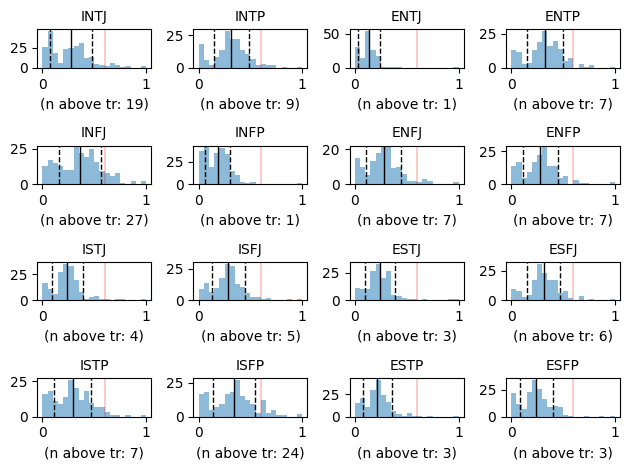

In [99]:
def plot_scores_distrib(scores: pd.Series, treshold: float = None):

    """Plot types scores distributions in 16 different histograms, 
    together with mean, std deviation and a treshold line (if provided).

    If a treshold is provided, we also count the  number of sentences above it."""

    print("Average Nr. of sentences per type:\t", 
        scores.apply(len).mean())
    
    if treshold is not None:
        print("Treshold:\t", treshold)

    i = 1
    for t in scores.keys():

        t_scores = [score for (_, score) in scores[t]]

        plt.subplot(4, 4, i)
        plt.hist(
            [score for (_, score) in scores[t]],
            bins=20, 
            alpha=0.5, 
            label=t)
        # plot mean as a vertical line
        plt.axvline(np.mean(t_scores), color='k', linewidth=1)

        # plot std deviation as vertical lines
        plt.axvline(np.mean(t_scores) + np.std(t_scores), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(t_scores) - np.std(t_scores), color='k', linestyle='dashed', linewidth=1)
        plt.title(t, fontsize=10)

        # if we have a treshold, count how many sentences are above it
        if treshold is not None:
            n_above_tr = len([
                score for score in t_scores 
                if score > treshold ])
            plt.axvline(treshold, color='red', linewidth=0.3)
            plt.xlabel("(n above tr: " + str(n_above_tr) + ")")

        plt.tight_layout()
        i += 1

print("Plot scores distributions for tf.idf scores")
plot_scores_distrib(type_scored_sentences_tfidf, treshold=0.6)


Plot scores distributions for frequencies scores
Average Nr. of sentences per type:	 176.1875
Treshold:	 0.6


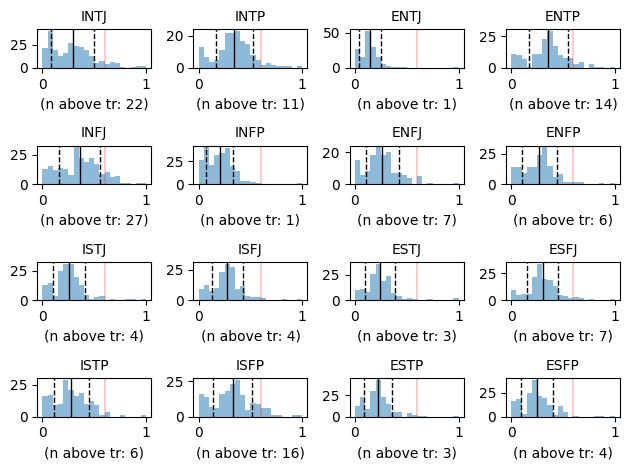

In [100]:
print("Plot scores distributions for frequencies scores")
plot_scores_distrib(type_scored_sentences_freq, treshold=0.6)

**Observations**: 

- we can see that the distribution of scores is very different for each type
- we can see that this happens both with discriminant scores and with simple frequency scores
- (min-max normalization is not enough to uniform the distributions)
- we can see that if we fix an arbitrary treshold (e.g., 0.6) we obtain that some types have very few sentences above the treshold, while other types have a lot of them


**Consequences**:
 
- to produce summaries (at least on full-texts) we cannot rely on a single treshold for all types
- we could use a classic mean + standard deviation normalization, or equivalently we can use a treshold based on some of those measures:
  - quantiles (so we obtain a sort of relative top-k sentences)
  - a treshold based on the mean + standard deviation (e.g., $treshold = mean + \alpha * std$)

In [101]:

def calculate_treshold(sentences: List[Tuple[str, float]], alpha: float = 1) -> float:
    """Calculate a treshold for a list of scored sentences
    which depends on the mean and standard deviation of the scores. 
    
    The treshold is calculated as: mean + alpha*std_deviation"""

    scores = [score for _, score in sentences]
    return np.mean(scores) + alpha*np.std(scores)


def summarize_by_treshold(
        sentences: List[Tuple[str, float]], 
        treshold: float, 
        sep: str=" ") -> str:
    """Select only sentences with a score above a certain treshold
    and merge them in an unique summary"""

    summary = ""
    for sentence, score in sentences:
        if score > treshold:
            summary += sentence + sep

    return summary

def save_summary(summary: str, type_name: str, method: str) -> None:
    """Save a summary in a text file"""

    if not os.path.exists(f'data/summary/{method}'):
        os.makedirs(f'data/summary/{method}')

    with open(f'data/summary/{method}/{type_name}.txt', 'w') as f:
        f.write(summary)

# ------------------------------
# Apply (fulltext) summarization to 
# all types, using both tf.idf and frequencies

sample_types = types.index 
# sample_types = ['INTJ', 'ENFP', 'ISFJ']

sentences_scores = {
    "fulltext/freq": type_scored_sentences_freq, 
    "fulltext/tfidf": type_scored_sentences_tfidf, 
    }

fulltext_summaries = defaultdict(dict)

for t in sample_types:
    for method, scores in sentences_scores.items():
        tr = calculate_treshold(scores[t], alpha=1.2)
        s = summarize_by_treshold(scores[t], tr, sep="\n")
        fulltext_summaries[t][method] = s
        save_summary(s, t, method)
        

Display two summaries as examples: 

In [102]:
print("INTJ - tfidf based summary\n")
print(fulltext_summaries['INTJ']['fulltext/tfidf'])

INTJ - tfidf based summary

Architects question everything.
But ever-skeptical Architects prefer to make their own discoveries.
Architects want to be successful, not just inventive.
Architects aren’t known for being warm and fuzzy.
This personality type is full of contradictions.
Rational – Architects pride themselves on their minds.
Informed – Few personality types are as devoted as Architects to forming rational, evidence-based opinions.
Creative and self-motivated, Architects strive to do things their own way.
Determined – Architect personalities are ambitious and goal-oriented.
Arrogant – Architects might be knowledgeable, but they’re not infallible.
Dismissive of Emotions – For Architects, rationality is king.
Architects seek strong, meaningful relationships.
But this doesn’t mean that Architects are antisocial or friendless.
Architects care about depth and quality.
It’s not always easy to befriend an Architect.
And for Architects who choose to have children, few challenges may be

In [103]:
print("ENFP - frequency based summary\n")
print(fulltext_summaries['ENFP']['fulltext/freq'])

ENFP - frequency based summary

The Campaigner personality is a true free spirit.
Campaigners are very emotional and sensitive, and when they step on someone’s toes, they both feel it.
For people with the Campaigner personality type, relationships are a joyous process of mutual exploration and imagination, a chance to connect with another soul.
Campaigners have the advantage of irresistible charm when it comes to attracting a partner – Campaigners’ warmth, excitement and passion are simply alluring.
These personality types may never be able to reciprocate the breadth of human interest that Campaigners present, but they do appreciate Campaigners’ efforts.
This can be a challenge for people with the Campaigner personality type – they have strong emotions, and invest those emotions heavily in the things and people they care about.
People with the Campaigner personality type need to feel like they’re pushing boundaries and exploring ideas, and should focus on interests and careers that enc

In [104]:
print("ISTJ - tf.idf  based summary\n")
print(fulltext_summaries['ISTJ']['fulltext/tfidf'])

ISTJ - tf.idf  based summary

The Logistician personality type is thought to be the most abundant, making up around 13% of the population.
Honest and Direct – Integrity is the heart of the Logistician personality type.
Patient and determined, people with the Logistician personality type meet their obligations, period.
Truly unstructured environments leave Logisticians all but paralyzed.
Logistician friends are not spontaneous.
What Logistician friends are is loyal, trustworthy, honorable and dependable.
Logisticians are a very methodical personality type, and this loyalty isn’t given away lightly.
People with the Logistician personality type don’t like conflict, and this applies to how they select their friends as well.
As parents, people with the Logistician personality type are often the most comfortable.
Logisticians love responsibility and the power resulting from it.
Few personality types are as practical and dedicated as Logisticians.
What you have read so far is just an introduc

### Final observations, Further possible developments

**Conclusions**:

- summaries are quite okay
- "peculiar" types have more "peculiar" summaries, while "common" types summary may lack of precision
  - sentence scoring summaries have the advantage on focusing on "discriminant" traits...
- the phrases may be a bit "disconnected" and some phrases, taken alone, may be not so meaningful

**Further possible developments**:

- we can  think about *comparative summaries* between two types
  - we can use tf.idf scores on only 2 types to enligthen their differences
    - so the more important tokens foreach types will be the ones "more specific of that type"
  - we can use an unique token scores for both types (e.g., sum of frequencies of the two corpus, but filtering out words that appear a lot also in other types) to enligthen their similarities
- today there exist more complex summarization tools (e.g., transformers-based, etc.)

## Clustering and grouping of MBTI types

### Goals (questions)

> Can we group the MBTI types in clusters? Are there any similarities emerging from the types descriptions? Can we find an unique partitioning or groupings are overlapped?

**Tools and techniques**: *clustering, PCA*

### Proposed solution and work pipeline

**Proposed solution**: use a clustering algorithm on a TF-IDF representation of the (full-text) corpus of each type and plot the results using a PCA. To endeep the difference between types, we can also use part-of-speech tagging to select only nouns, verbs and adjectives and try to cluster only them.

**Work pipeline**:

- preprocessing (as before, but without n-grams)
  - alternatively, another preprocessing based on part-of-speech tagging to extract only some parts of speech (e.g., nouns, verbs, adjectives)
- generate a TF-IDF representation of the corpus (applying appropriate filters)
- apply a clustering algorithm (e.g., K-Means)
- apply a PCA to plot the results in a 2D space


### Alternative choices and issues

**Alternative choices**:

- experiment different kinds of clustering algorithms (e.g., K-Means vs hierarchical clustering)
  - for now, we will focus just on K-Means
- experiment different kinds of filters on features (e.g., min-max document frequency)
- experiment what happens if we focus only on some parts of speech (e.g., nouns, verbs, adjectives)

**Found issues**:

- different term frequency filters may bring to different results
- also different random seeds may bring to different results

In [105]:
# extract tokens from sentences and merge them in an unique text
# [Needed time: 20 seconds]

types_ft_tokens = df_types_ft["corpus"].apply(
    # we remove types letters and nicknames because they are over-represented
    lambda x: preprocessing(x, other_stopwords=types_letters_and_nicknames)
    ).apply(lambda x: " ".join(x))

In [106]:
def print_top_n_cluster_keywords(
    X, 
    kmeans: KMeans,
    types_names: List[str],
    feature_names: List[str],
    n_keywords: int = 10, ) -> None:
    """Print clusters and their top n_keywords"""

    # build a temp df with types and clusters
    df = pd.DataFrame(X.todense())
    df['Cluster'] = kmeans.labels_
    df['type'] = types_names
    df.set_index('type', inplace=True)

    # calculate the mean of each cluster
    cluster_values = df.groupby('Cluster').mean()

    # print clusters types and top n_keywords
    for i,r in cluster_values.iterrows():
        print(f"Cluster {i}:\t", df[df["Cluster"] == i].index.values)
        print(", ".join([feature_names[j] for j in np.argsort(r)[-n_keywords:]]))

def plot_clusters_pca(
    X,
    kmeans: KMeans,
    types_names: List[str], 
    random_state: int = 0) -> None:
    """Plot clusters in a 2D space using PCA"""

    # apply PCA and extract first 2 components
    pca_vecs = PCA(n_components=2, random_state=random_state).fit_transform(X.toarray())
    x0 = pca_vecs[:,0]
    x1 = pca_vecs[:,1]

    # plot clusters in the 2D space
    df = pd.DataFrame({
        'PCA_X0': x0, 
        'PCA_X1': x1, 
        'Cluster': kmeans.labels_, 
        'type': types_names}).set_index('type')
    
    sns.scatterplot(data=df, x="PCA_X0", y="PCA_X1", hue="Cluster", palette="tab10")

    plt.title("PCA of the 16 types vectors")
    plt.xlabel("PCA X0")
    plt.ylabel("PCA X1")
    
    # add types labels to the points
    def label_point(x, y, val, ax):
        a = pd.DataFrame({'x': x, 'y': y, 'val': val})
        for i, point in a.iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))

    label_point(df["PCA_X0"], df["PCA_X1"], df.index, plt.gca())

    plt.tight_layout()

def kmeans_cluster_and_pca(
    types_tokens: pd.Series,
    n_clusters: int = 5,
    n_keywords: int = 10,
    ngram_range: Tuple[int, int]=(1,1), 
    min_df: int=1, 
    max_df: float=1.0, 
    random_state: int = 0, 
    print_clusters: bool = True, 
    plot_pca: bool = True, 
    ) -> KMeans:

    """
    Apply kmeans clustering algorithm to a series of texts and use
    PCA to display the results in a 2D plot. It also prints found 
    clusters and their top n_keywords.

    Args:
        types_tokens: series of texts
        n_clusters: number of clusters you want to extract
        k_keywords: number of keywords to print from each cluster
        ngram_range: range of ngrams to consider
        min_df: minimum document frequency
        max_df: maximum document frequency
        random_state: random state for reproducibility
        print_clusters: if True, print clusters and their top n_keywords
        plot_pca: if True, plot clusters in a 2D space using PCA

    Returns:
        kmeans: fitted kmeans model
        X: vectorized texts
        feature_names: vectorized texts feature names
    """

    # vectorize texts using tfidf and applying passed filters
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform(types_tokens)

    # apply kmeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto').fit(X)

    # print clusters and their top n_keywords
    if print_clusters:
        print_top_n_cluster_keywords(
            X, kmeans, 
            types_names=types_tokens.index, 
            feature_names=vectorizer.get_feature_names_out(), 
            n_keywords=n_keywords )

    # apply PCA to reduce dimensionality to 2 and plot results
    if plot_pca:
        plot_clusters_pca(X, kmeans, types_tokens.index, random_state=random_state)

    return kmeans, X, vectorizer.get_feature_names_out()
    
    

Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
clear, practical, tradition, done, authority, social, family, respect, responsibility, dedication
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP']
logic, freedom, natural, insight, chance, social, debate, thought, interest, intellectual
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
generally, perfect, grow, fortunately, insight, said, employee, may feel, value, might
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
action, day, experience, live, planning, relaxed, practical, fun, activity, moment


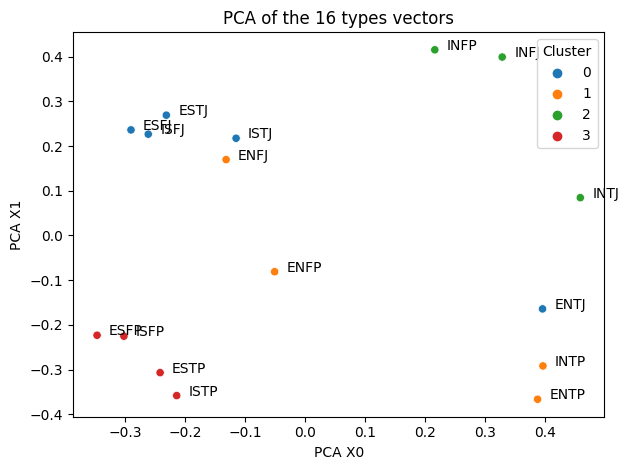

In [107]:
# Clustering Nr 01: initial setting that gives a decent result
_, _, _, = kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2), 
    min_df=3, max_df=0.9, 
    random_state=0, 
    )

Observations: 

- the clusters seems meaningful (both according to grouping and to )
  - 0: "tradition and authority" oriented types
  - 1: "logic, intellect and debate" oriented types
  - 2: "insight and value" oriented types
  - 3: "action and experience" oriented types
- the position of the dots in the first two PCA dimensions seems related to what we found in clustering
  - $X_0$ axis seems related to "intuition" VS "sensation"
  - $X_1$ axis seems related to "perceiving" VS "judging"
- some cluster are more concentrated in PCA space than others


...but are we sure that the clustering is really meaningful?

### Experiment more min-max document frequency filters

Clustering Nr. 02: no frequency filters
Cluster 0:	 ['ENTJ' 'ISTJ' 'ESTJ']
relationship, others, often, work, people personality, make, personality type, type, people, personality
Cluster 1:	 ['ISFJ' 'ESFJ']
friend, take, often, social, make, need, personality type, type, people, personality
Cluster 2:	 ['INTJ' 'INTP' 'ENTP' 'INFJ' 'INFP' 'ENFJ' 'ENFP']
idea, even, find, need, people personality, may, personality type, type, people, personality
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
come, child, people personality, make, thing, need, personality type, people, type, personality


Clustering Nr. 03: stricter frequency filters
Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
standard, stable, loyalty, duty, established, tradition, authority, family, respect, dedication
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP']
bring, theory, analyst, conversation, genuine, logic, insight, chance, debate, intellectual
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
may find, inner, independence, ideal, perfect, gene

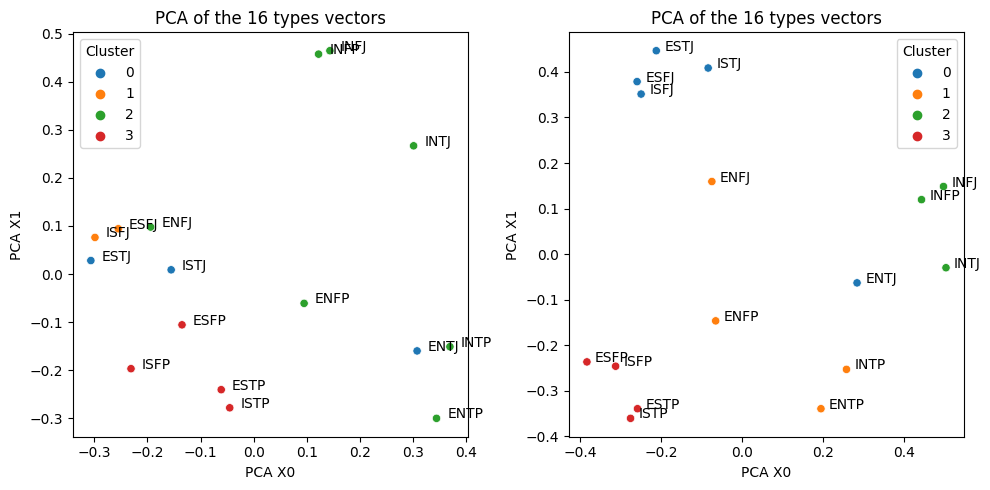

In [108]:
plt.figure(figsize=(10, 5))

print("Clustering Nr. 02: no frequency filters")
plt.subplot(1, 2, 1)
_, _, _, = kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2),     
    random_state=0, 
)

print("\n")
print("Clustering Nr. 03: stricter frequency filters")
plt.subplot(1, 2, 2)
_, _, _, = kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=4, 
    n_keywords=10, 
    ngram_range=(1,2), 
    min_df=5, max_df=10, 
    random_state=0, 
    )




Observations:

- removing all frequency filters brings to different results
  - all "big intuitives" are grouped together in cluster 2
  - cluster 3 ("sensorial" types) is the same
  - the precedent cluster 0 ("tradition and authority") is now splitted in two: 0 and 1 (according to the "feelings" VS "thinking" dichotomy)
- top 10 mean words are less discriminant than before 
  - (all clusters seems described by very generic words like "type", "personality", etc.)
- dots in PCA space are less concentrated than before
  - axis $X_0$ seems againg related to "intuition" VS "sensation", and axis $X_1$ seems (slighly) related to "perceiving" VS "judging"
- with stricter filters, we obtain a similar result to the first setting
  - maybe top mean terms are a bit more clear


Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
fact, community, authority, practical, tradition, responsibility, respect, social, family, dedication
Cluster 1:	 ['ENFJ' 'ENFP']
physical, team, mean, excitement, natural, heart, chance, genuine, idealism, interest
Cluster 2:	 ['INFJ' 'INFP']
deep, grow, belief, ideal, idealism, employee, said, may feel, value, might
Cluster 3:	 ['ISFP' 'ESFP']
live, relaxed, exciting, activity, appreciated, fun, style, experience, planning, moment
Cluster 4:	 ['ISTP' 'ESTP']
change, interesting, action, relaxed, fun, habit, hobby, moment, practical, activity
Cluster 5:	 ['INTJ' 'INTP' 'ENTJ' 'ENTP']
prove, logic, social, point, achieve, debate, thought, rational, insight, intellectual


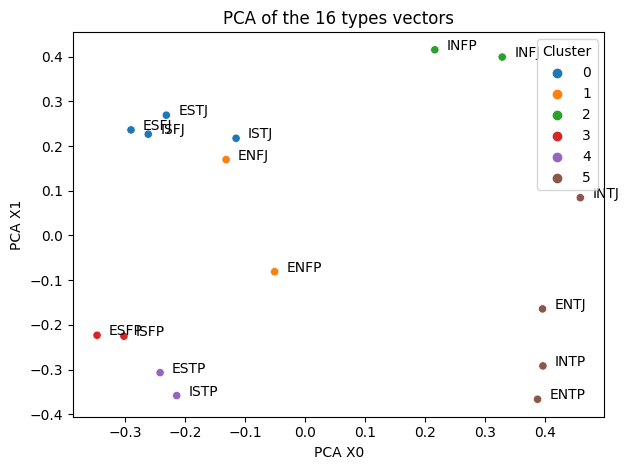

In [109]:
# Clustering Nr. 04: attempt 6 clusters
_, _, _, = kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=6, 
    n_keywords=10, 
    ngram_range=(1,2), 
    min_df=3, max_df=0.9, 
    random_state=0, 
    )

Cluster 0:	 ['ISTJ' 'ESTJ' 'ESFJ']
clear, community, tradition, family, fact, authority, dedication, responsibility, social, respect
Cluster 1:	 ['ENFP']
shine, experience, mutual, idealism, spirit, big, physical, excitement, chance, interest
Cluster 2:	 ['INFJ' 'INFP']
deep, grow, belief, ideal, idealism, employee, said, may feel, value, might
Cluster 3:	 ['ISTP' 'ISFP' 'ESFP']
live, freedom, day, fun, planning, experience, practical, activity, moment, relaxed
Cluster 4:	 ['INTJ' 'INTP' 'ENTJ' 'ENTP']
prove, logic, social, point, achieve, debate, thought, rational, insight, intellectual
Cluster 5:	 ['ESTP']
action, habit, charming, change, rule, risk, living, discussion, fun, moment
Cluster 6:	 ['ENFJ']
sort, inspiring, heart, idealistic, charismatic, believe, idealism, helping, team, genuine
Cluster 7:	 ['ISFJ']
helping, change, practical, warm, ensuring, altruism, customer, kindness, family, dedication


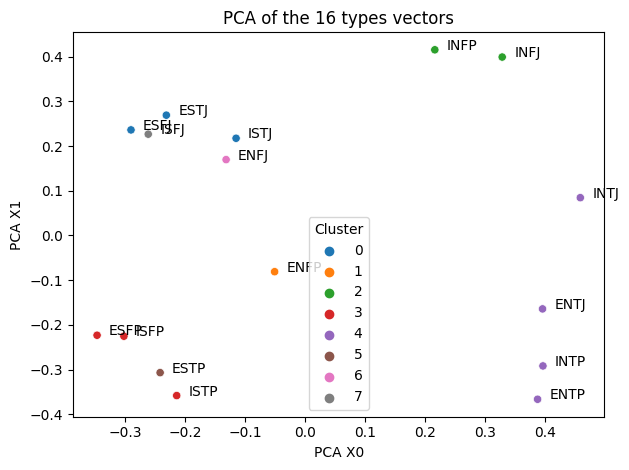

In [110]:
# Clustering Nr. 05: attempt 8 clusters
_, _, _, = kmeans_cluster_and_pca(
    types_ft_tokens, 
    n_clusters=8, 
    n_keywords=10, 
    ngram_range=(1,2), 
    min_df=3, max_df=0.9, 
    random_state=0, 
    )


Observation: 

- augmenting to 6 clusters leads to groupings closer to the letters dichotomies and the usually reported groupings (https://www.16personalities.com/personality-types )
  - Analysts (Intuitive Thinkers - `'*NT*'`)
  - Diplomats (Intuitive Feelers - `'*NF*'`)
  - Sentinels (Judging Sensors - `'*S*J'`)
  - Explorers (Perceiving Sensors - `'*S*P'`)
- augmenting to 8 clusters instead generates more one-dots clusters


### Clustering on just some parts of speech

Now we try to extract just nouns, verbs and adjectives from the corpus and we try to cluster them.

In [111]:
def pos_extraction_preprocessing(
        text: str, 
        pos_parts: List[List[str]] = [['NOUN'], ['VERB'], ['ADJ'], ['ADV']],
        n_ngrams: int = 1, 
        lemmatizer: WordNetLemmatizer = lemmatizer, 
        other_stopwords: List[str] = [], 
        ) -> Dict[str, List[str]]:
    """
    Text preprocessing focused on extracting separately 
    some parts of speech. Output is a dictionary with
    keys corresponding to the parts of speech and values
    corresponding to the list of extracted tokens.
    """
    
    # to lower case and tokenization
    tokens = nltk.word_tokenize(text.lower())

    # pos tagging
    pos = nltk.pos_tag(tokens, tagset='universal')

    # extract parts of speech
    res = {}
    for parts in pos_parts:

        parts_name = ','.join(parts)

        # extract just a specific part of speech and
        # place it in the dictionary
        res[parts_name] = [ 
            token for (token, tag) in pos 
            if tag in parts ]
        
        # remove other stopwords
        res[parts_name] = [
            token for token in res[parts_name] \
            if token not in other_stopwords
            ]

        # lemmatization
        if lemmatizer is not None:
            res[parts_name] = [
                lemmatizer.lemmatize(token) 
                for token in res[parts_name] ]

        if n_ngrams <= 1:
            continue
    
        # n-grams generation
        generated_ngrams = res[parts_name].copy()

        for i in range(2, n_ngrams + 1):
            processed_text = ngrams(res[parts_name], i)
            generated_ngrams += [' '.join(grams) for grams in processed_text]

        res[parts_name] = generated_ngrams

    return res

In [112]:
# extract just nouns, verbs, adjectives and adverb
# [Needed time: 5s]

pos_tagged_tokens = df_types_ft["corpus"].apply(
    lambda x: pos_extraction_preprocessing(
        x, pos_parts=[
            ['NOUN'], ['VERB'], ['ADJ'], 
            ['NOUN', 'VERB'], ['NOUN', 'ADJ']], 
        n_ngrams=1,
        lemmatizer=None, # no lemmatization
        other_stopwords=types_letters_and_nicknames)
    )

nouns_tokens = pos_tagged_tokens.apply(lambda x: x['NOUN']).apply(lambda x: ' '.join(x))
verbs_tokens = pos_tagged_tokens.apply(lambda x: x['VERB']).apply(lambda x: ' '.join(x))
adjectives_tokens = pos_tagged_tokens.apply(lambda x: x['ADJ']).apply(lambda x: ' '.join(x))
# nouns_verbs_tokens = pos_tagged_tokens.apply(lambda x: x['NOUN,VERB']).apply(lambda x: ' '.join(x))
# nouns_adjectives_tokens = pos_tagged_tokens.apply(lambda x: x['NOUN,ADJ']).apply(lambda x: ' '.join(x))


4 clusters on nouns:
Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
qualities, roles, responsibilities, facts, family, responsibility, support, authority, respect, dedication
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP']
person, efforts, idea, freedom, idealism, qualities, problems, theories, chance, interest
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
independence, self, insight, idealism, relationship, result, lives, values, times, employees
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
spontaneity, joy, style, freedom, action, fun, focus, activities, day, moment


6 clusters on nouns:
Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
responsibility, values, care, loyalty, facts, family, authority, support, respect, dedication
Cluster 1:	 ['ENFJ' 'ENFP']
lessons, role, quality, problems, excitement, relationship, interest, chance, efforts, idealism
Cluster 2:	 ['INFJ' 'INFP']
dreams, relationship, purpose, beliefs, lives, times, result, idealism, values, employees
Cluster 3:	 ['ISFP' 'ESFP']
fun, planning,

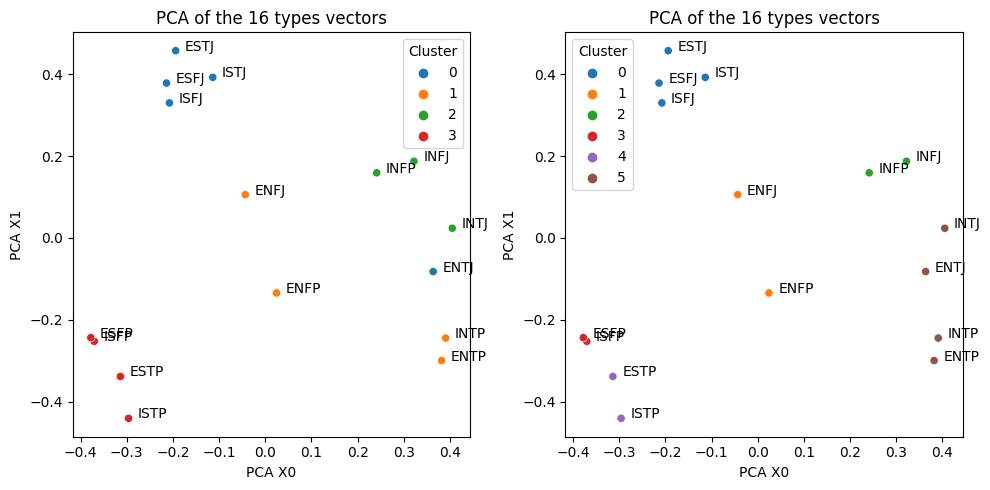

In [113]:
# Clustering just on nouns
plt.figure(figsize=(10, 5))

print("4 clusters on nouns:")
plt.subplot(1, 2, 1)
_, _, _, = kmeans_cluster_and_pca(
    nouns_tokens,
    n_clusters=4,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9,
    random_state=0, 
    )

print("\n")

print("6 clusters on nouns:")
plt.subplot(1, 2, 2)
_, _, _, = kmeans_cluster_and_pca(
    nouns_tokens,
    n_clusters=6,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9,
    random_state=0, 
    )


4 clusters on verbs:
Cluster 0:	 ['INTP' 'ENTJ' 'ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
managing, are need, say, must, get done, recognize, expect, achieve, ensure, established
Cluster 1:	 ['ENFJ' 'ENFP']
establish, are have, bring, giving, experience, inspire, shine, explore, helping, means
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
can find, can help, can become, care, may need, can make, may find, said, may feel, might
Cluster 3:	 ['ENTP' 'ISTP' 'ISFP' 'ESTP' 'ESFP']
need be, engage, be can, appreciated, bored, allows, know are, getting, move, live


6 clusters on verbs:
Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ' 'ESFJ']
finished, bring, helping, expect, ensuring, creating, are need, maintain, ensure, established
Cluster 1:	 ['ENFJ' 'ENFP']
establish, are have, bring, giving, experience, inspire, shine, explore, helping, means
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
can find, can help, can become, care, may need, can make, may find, said, may feel, might
Cluster 3:	 ['ISFP' 'ESFP']
are take, plan, does, are need, e

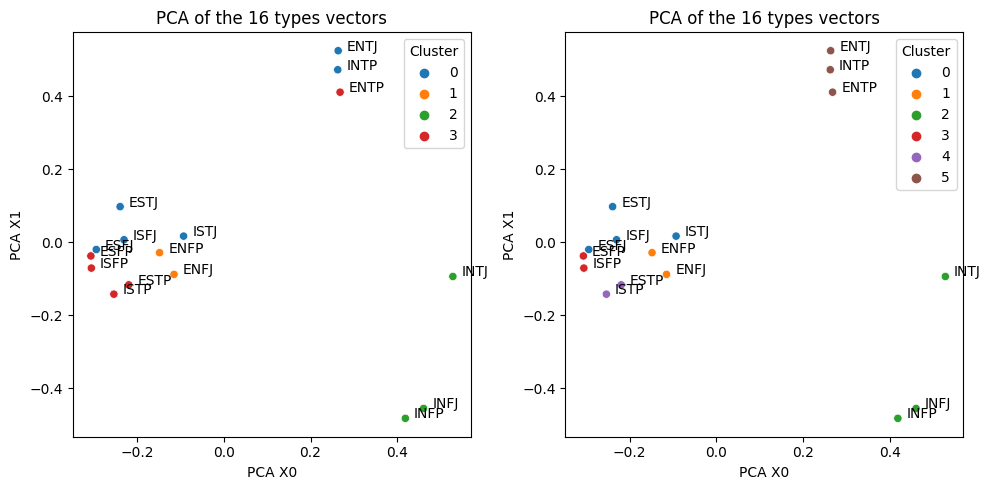

In [114]:
# Clustering just on verbs

plt.figure(figsize=(10, 5))

print("4 clusters on verbs:")
plt.subplot(1, 2, 1)
_, _, _, = kmeans_cluster_and_pca(
    verbs_tokens,
    n_clusters=4,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.8,
    random_state=0, 
    )

print("\n")

print("6 clusters on verbs:")
plt.subplot(1, 2, 2)
_, _, _, = kmeans_cluster_and_pca(
    verbs_tokens,
    n_clusters=6,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.8, 
    random_state=0, 
    )

4 clusters on adjectives:
Cluster 0:	 ['ENTJ' 'ISTJ' 'ISFJ' 'ESTJ']
high, mutual, natural, such, stubborn, rational, long, practical, stable, clear
Cluster 1:	 ['INTP' 'ENTP' 'ENFJ' 'ENFP' 'ESFJ']
physical, genuine, important, such, open, happy, willing, natural, intellectual, social
Cluster 2:	 ['INTJ' 'INFJ' 'INFP']
capable, social, quiet, meaningful, deep, difficult, ideal, few, re, perfect
Cluster 3:	 ['ISTP' 'ISFP' 'ESTP' 'ESFP']
social, happy, exciting, hands, hands on, on, practical, long term, term, long


6 clusters on adjectives:
Cluster 0:	 ['ISTJ' 'ISFJ' 'ESTJ']
well, such, responsible, willing, mutual, long, stubborn, practical, clear, stable
Cluster 1:	 ['ENFJ' 'ENFP' 'ESFJ']
important, esteem, self esteem, physical, mutual, willing, natural, happy, genuine, social
Cluster 2:	 ['INFJ' 'INFP']
creative, difficult, inner, few, capable, re, ideal, quiet, deep, perfect
Cluster 3:	 ['ISFP' 'ESFP']
artistic, fun, exciting, practical, happy, tangible, social, long, long term, te

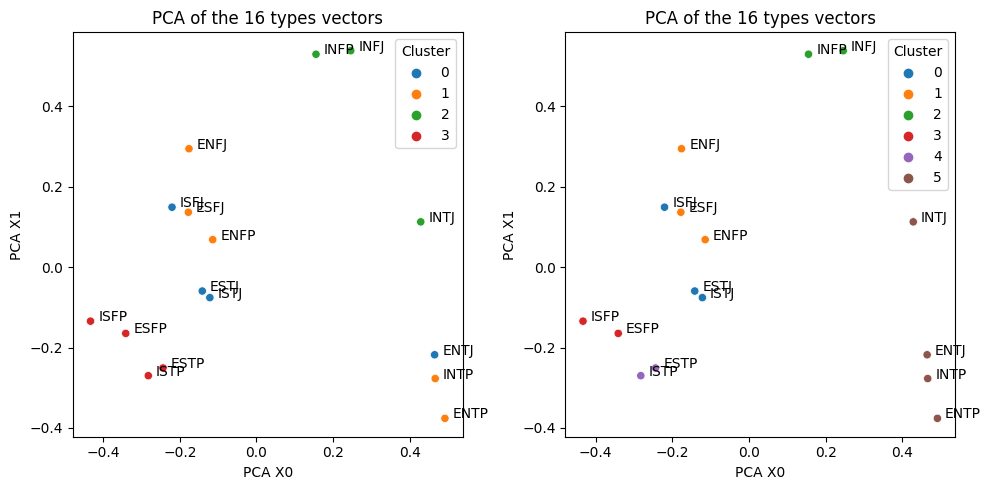

In [115]:
# Clustering just on adjectives

plt.figure(figsize=(10, 5))

print("4 clusters on adjectives:")
plt.subplot(1, 2, 1)
_, _, _, = kmeans_cluster_and_pca(
    adjectives_tokens,
    n_clusters=4,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9, 
    random_state=0, 
    )

print("\n")

print("6 clusters on adjectives:")
plt.subplot(1, 2, 2)
_, _, _, = kmeans_cluster_and_pca(
    adjectives_tokens,
    n_clusters=6,
    n_keywords=10,
    ngram_range=(1,2),
    min_df=3, max_df=0.9,
    random_state=0, 
    )


Observations:

- making this POS-based clustering, we obtain similar results to what we already found
- as before, some groupings hold more than others
- Most of configurations are already known, but some are new
  - E.g., `'ENFJ' 'ENFP' 'ESFJ'` <-- "esteem" and "social"

### Final observations, Further possible developments

**Final observations**:

- it seems there isn't a single "correct" way to cluster the MBTI types
- ...but some groupings hold more than others
  - some pairs of types are more often coupled than others
  - e.g., `('INFP', 'INFJ'), ('ISFJ', 'ESFJ'), ('INTP', 'ENTP'), ('ISTJ', 'ESTJ')`
  - generally speaking, stable relationships seems related to the letters
- the change of some grouping suggest some types may have more "facades"
  - e.g., `'ENFP'` are "thought and debate" oriented, but they are also very "social"
  - e.g., `'INTJ'` are "logic" people, but they also rely a lot on "insight" and value a lot their "indipendece"
  - e.g., `'ENTJ'` are attached to "hierarchy and duty", but he is also an "intuitive thinker"
- the change of clusters is both caused by filters and by pure randomness
- according to how types are plotted in PCA, the "intuition" vs "sensation" dichotomy seems always to be the more relevant
  - another recurrent but less well defined dichotomy is "judging" vs "perceiving"
  - "thinking" vs "feeling", "introversion" vs "extroversion" seem less clear
- applying the algorithm on just some parts of speech don't bring so much new information, but it confirms what we already found

**Further possible developments**:

- we tried only one clustering algorithm (K-Means), what about others?
  - e.g., hierarchical clustering, DBSCAN, etc.
  - we can endeep the search of an optimal number of clusters
- we can try to rely to more complex data representations (e.g., word embeddings) and see what happens


## Topic modelling on MBTI types

### Goal (questions)

> Can we map types in some latent feature space? Do clustering groupings correspond to some latent topics?

**Tools and techniques**: *topic modeling (LDA)*

### Proposed solution and work pipeline

We can use topic modeling (in particular, LDA) to try to extract topics from the collection. Ideally, we want to extract latent topics that models MBTI types characteristics.


**Work pipeline**:

1. preprocessing (as before)
2. build a dictionary
    - (to associate each word to a unique id)
3. vectorize the corpus into a bag-of-words representation 
    - (with ids instead of textual tokens)
4. generate a LDA model


### Alternative choices and issues

**Alternative choices**:

- do we apply some filtering on the dictionary?
  - e.g., min-max document frequency
- experiment with more or less topics
  - we can experiment with "meaningful" numbers of topics
  - e.g., $8 \rightarrow$ the number of Jung cognitive functions 
    - $\{intuition, sensing, thinking, feeling\} x \{extraverted, introverted \}$
    - (e.g., "extraverted intuition", "introverted intuition", "extraverted thinking", "extraverted thinking", etc.)

**Found issues**:

- instead of many meaninful latent topics, we obtain "generic" topics
  - (e.g., "type", "personality", "people", "life", etc.)
  - solution: we can try to filter out some words (e.g., stopwords, etc.)
- we may obtain that 2 or more types are descibed by an unique equal topic, not enligthening their differences
  - partial solution: 
    - we can try different random seeds (brute force), 
    - we can try to measure and maximize heterogeneity of topics
    - we can try to explore the best results and choose a good (random) configuration that enligthen as many differences as possible 
  - we have to accept the fact that LDA has no constraint that forces each pair of document to be described by a different configuration of topics... 



In [116]:
# [Needed time: 15s]

# extract tokens 
all_tokens = df_types_ft["corpus"].apply(
    lambda x : preprocessing(
        x, other_stopwords=types_letters_and_nicknames))

# make a dictionary
all_tokens_dict = gensim.corpora.Dictionary(all_tokens)

# convert tokenized documents into a document-term matrix
lda_corpus = all_tokens.apply(lambda x: all_tokens_dict.doc2bow(x))


In [117]:
# generate a first  LDA model
# [Needed time: 12s]

lda_model = gensim.models.LdaMulticore(
    lda_corpus, 
    num_topics=5,  
    id2word=all_tokens_dict, 
    passes=10,
    random_state=0,)

# print found topics
for t in lda_model.print_topics(num_words=7):
    print(t)

(0, '0.017*"personality" + 0.012*"type" + 0.012*"people" + 0.007*"thing" + 0.006*"make" + 0.006*"friend" + 0.005*"take"')
(1, '0.017*"personality" + 0.013*"type" + 0.013*"people" + 0.007*"need" + 0.007*"make" + 0.007*"often" + 0.006*"others"')
(2, '0.021*"personality" + 0.017*"people" + 0.015*"type" + 0.011*"may" + 0.009*"need" + 0.007*"make" + 0.007*"child"')
(3, '0.015*"personality" + 0.010*"type" + 0.010*"idea" + 0.008*"people" + 0.007*"find" + 0.005*"others" + 0.005*"new"')
(4, '0.015*"personality" + 0.010*"people" + 0.010*"type" + 0.007*"make" + 0.007*"thing" + 0.004*"need" + 0.004*"life"')


**Observations**: 

- we obtained very generic topics. All topics seems too similar and results don't us nothing meaningful.
- main terms in topics are very generic and very similar 
  - we just understood that more or less all the documents are about "types", "personalities", "people", "life", etc.

**ideas**:

- we can try to filter out all the generic words
  - words which are too frequent in the whole corpus
  - words which does not discriminate the documents
- maybe we did something wrong in LDA algorithm?
  - too many vs too few interations
  - too many vs too few topics
- maybe the types descriptions, after all, talks about the same things


### Filter out generic words 

How can we filter out generic words?

**Solution**: treshold on document frequency

- potential issue: a word may appear in many documents, but it may be discriminant for some types
- e.g., "people" is a very generic word, but it may be discriminant for "social" types, etc.

In [118]:
# [Needed time: 10s]

# make two new dictionaries with different filters on 
# tokens document frequencies
filtered_tokens_dict_1 = gensim.corpora.Dictionary(all_tokens)
filtered_tokens_dict_1.filter_extremes(no_above=0.7)

filtered_tokens_dict_2 = gensim.corpora.Dictionary(all_tokens)
filtered_tokens_dict_2.filter_extremes(no_above=0.9)

# convert tokenized documents into a document-term matrix
lda_corpus_filtered_1 = all_tokens.apply(lambda x: filtered_tokens_dict_1.doc2bow(x))
lda_corpus_filtered_2 = all_tokens.apply(lambda x: filtered_tokens_dict_2.doc2bow(x))

# generate the new LDA models on filtered tokens
lda_model_filtered_1 = gensim.models.LdaMulticore(
    lda_corpus_filtered_1,
    num_topics=5,
    id2word=filtered_tokens_dict_1,
    passes=10,
    random_state=0,)

lda_model_filtered_2 = gensim.models.LdaMulticore(
    lda_corpus_filtered_2,
    num_topics=5,
    id2word=filtered_tokens_dict_2,
    passes=10,
    random_state=0,)


# print found topics
print("LDA model with no_above=0.7")
for t in lda_model_filtered_1.print_topics(num_words=5):
    print(t)

print("\nLDA model with no_above=0.9")
for t in lda_model_filtered_2.print_topics(num_words=5):
    print(t)



LDA model with no_above=0.7
(0, '0.002*"might" + 0.002*"said" + 0.002*"insight" + 0.002*"respect" + 0.002*"employee"')
(1, '0.009*"thought" + 0.008*"respect" + 0.008*"rational" + 0.007*"intellectual" + 0.006*"achieve"')
(2, '0.023*"might" + 0.014*"said" + 0.012*"employee" + 0.011*"ideal" + 0.009*"insight"')
(3, '0.013*"dedication" + 0.010*"family" + 0.009*"warm" + 0.009*"authority" + 0.008*"helping"')
(4, '0.009*"live" + 0.008*"interest" + 0.008*"fun" + 0.008*"action" + 0.007*"style"')

LDA model with no_above=0.9
(0, '0.010*"moment" + 0.008*"activity" + 0.007*"practical" + 0.007*"experience" + 0.007*"day"')
(1, '0.014*"social" + 0.009*"practical" + 0.009*"dedication" + 0.008*"warm" + 0.008*"done"')
(2, '0.008*"thought" + 0.006*"intellectual" + 0.006*"point" + 0.006*"debate" + 0.006*"social"')
(3, '0.011*"responsibility" + 0.011*"respect" + 0.010*"fact" + 0.008*"clear" + 0.008*"opinion"')
(4, '0.012*"might" + 0.011*"value" + 0.007*"grow" + 0.007*"social" + 0.007*"said"')


In [119]:
# print topis for each type
def print_document_topics(
        lda_model: gensim.models.LdaMulticore, 
        lda_corpus: pd.Series) -> None:
    """
    Print topics for each document in a corpus
    """

    for t,c in lda_corpus.items():
        print(f"{t}: ", lda_model[c])

print("Types topics for LDA model with no_above=0.9")
print_document_topics(lda_model_filtered_2, lda_corpus_filtered_2)

Types topics for LDA model with no_above=0.9
INTJ:  [(2, 0.017413352), (4, 0.9818558)]
INTP:  [(2, 0.9990897)]
ENTJ:  [(2, 0.998983)]
ENTP:  [(2, 0.9990575)]
INFJ:  [(4, 0.99893343)]
INFP:  [(4, 0.9988971)]
ENFJ:  [(0, 0.31569886), (1, 0.056093227), (2, 0.4854407), (3, 0.03389376), (4, 0.10887342)]
ENFP:  [(0, 0.66244376), (2, 0.14932518), (4, 0.18776195)]
ISTJ:  [(3, 0.99909526)]
ISFJ:  [(1, 0.99900156)]
ESTJ:  [(3, 0.9989569)]
ESFJ:  [(0, 0.17978518), (1, 0.3355288), (2, 0.05098669), (3, 0.43343508)]
ISTP:  [(0, 0.9989531)]
ISFP:  [(0, 0.9988932)]
ESTP:  [(0, 0.8244887), (2, 0.17464823)]
ESFP:  [(0, 0.7481922), (2, 0.020766862), (3, 0.07741042), (4, 0.15333681)]


Observations:

- the results obtained filtering out words with a document frequency higher than 0.9 seems pretty meaningful
  - there are no more generic topics
  - there are no too much similar topics
- we can see some similitudes with what we found in clustering
  - found topics maps the clustering groupings: 
    - "moment, activity and experience", 
    - "social dedication", 
    - "thought, intellectual and debate", 
    - "responsibility and respect", 
    - "value and growth"
  - types which were often clustered together are now often associated to the same topics
    - e.g., `('INFP', 'INFJ'), ('ISFJ', 'ESFJ'), ('INTP', 'ENTP'), ('ISTJ', 'ESTJ')`
  - (some of the) types which clusters were "not so stable" now are mapped to more than one topic!
    - e.g., `'ENFP'` is mapped to "thought, intellectual and debate", "social dedication" but also "moment, activity and experience"
    - e.g., `'INTJ'` is mapped to "thought, intellectual and debate" and "value and growth"
    - this may help describing better the more "complex" types
- the LDA algorithm is OK, we just needed a bit more of preprocessing


In [120]:
# LDA w doc freq filter + 8 topics
# [Needed time: 5s]

lda_model_8topics = gensim.models.LdaMulticore(
    lda_corpus_filtered_2,
    num_topics=8,
    id2word=filtered_tokens_dict_2,
    passes=20,
    random_state=0,)

print("\nLDA model with 8 topics")
for t in lda_model_8topics.print_topics(num_words=5):
    print(t)




LDA model with 8 topics
(0, '0.013*"moment" + 0.013*"activity" + 0.011*"practical" + 0.010*"day" + 0.010*"fun"')
(1, '0.001*"practical" + 0.001*"value" + 0.001*"done" + 0.001*"responsibility" + 0.001*"social"')
(2, '0.009*"thought" + 0.008*"rational" + 0.008*"intellectual" + 0.008*"point" + 0.007*"debate"')
(3, '0.012*"fact" + 0.011*"responsibility" + 0.010*"respect" + 0.008*"clear" + 0.008*"opinion"')
(4, '0.009*"value" + 0.008*"might" + 0.007*"social" + 0.007*"grow" + 0.006*"mean"')
(5, '0.001*"responsibility" + 0.001*"achieve" + 0.001*"thought" + 0.001*"leader" + 0.001*"point"')
(6, '0.001*"grow" + 0.001*"value" + 0.001*"change" + 0.001*"moment" + 0.001*"ability"')
(7, '0.017*"social" + 0.010*"practical" + 0.009*"dedication" + 0.007*"done" + 0.007*"responsibility"')


In [121]:
print_document_topics(lda_model_8topics, lda_corpus_filtered_2)

INTJ:  [(2, 0.40293768), (4, 0.5961666)]
INTP:  [(2, 0.9990278)]
ENTJ:  [(2, 0.9989133)]
ENTP:  [(0, 0.04501132), (2, 0.866958), (4, 0.087311745)]
INFJ:  [(4, 0.9988567)]
INFP:  [(4, 0.99882126)]
ENFJ:  [(4, 0.9988333)]
ENFP:  [(0, 0.1195541), (4, 0.87958795)]
ISTJ:  [(3, 0.9990322)]
ISFJ:  [(7, 0.9944599)]
ESTJ:  [(3, 0.99888414)]
ESFJ:  [(7, 0.9988742)]
ISTP:  [(0, 0.99887866)]
ISFP:  [(0, 0.5880758), (4, 0.410911)]
ESTP:  [(0, 0.5331482), (2, 0.2003059), (4, 0.26566857)]
ESFP:  [(0, 0.40969214), (4, 0.48703086), (7, 0.10238207)]


**Observations**:

- augmenting the number of topics, we still obtain what seems to be meaningful topics
- topics are not redundant

### Model types with latent features

Given achieved results, we can try to model each type as a vector of latent features (topics). We aim to look for a LDA configuration that maps each type to a different configuration of topics.

To do that, we try (brute force) different random seeds and different numbers of passes, measuring at each time the average similarity between the vectors of the types (and aiming to minimize it). Because this does not guarantee that each type is mapped to a different configuration of topics, we also tried manually some of the best configurations and we just chose one. 

In [122]:
def get_docs_vectors(
    lda: gensim.models.LdaMulticore, 
    lda_corpus: pd.Series ): 

    res = {}
    
    for type,c in lda_corpus.items(): 

        res[type] = [0]*lda.num_topics
        
        for topic,value in lda[c]:
            res[type][topic] = value

    return pd.Series(res)

def docs_vectors_avg_similarity(docs_vectors: pd.Series) -> float:
    """A measure of how much document vectors are similar to each other
    (calculated as the mean similarity between each pair of documents). 
    
    Since vectors are probability vectors, each similarity is in [0,1], 
    so the final similarity is in [0,1]."""

    vecs = list(docs_vectors)
    similarities = []

    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            s = np.dot(vecs[i], vecs[j])
            similarities.append(s)
    
    return np.mean(similarities)

def docs_vectors_max_similarity(docs_vectors: pd.Series) -> float:
    """A measure of how much document vectors are similar to each other
    (calculated as the max similarity between each pair of documents). 
    
    Since vectors are probability vectors, each similarity is in [0,1], 
    so the final similarity is in [0,1]."""

    vecs = list(docs_vectors)
    max_sim = 0

    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            s = np.dot(vecs[i], vecs[j])
            if s > max_sim:
                max_sim = s

    return max_sim

def docs_vectors_wmean_similarity(docs_vectors: pd.Series) -> float:
    """A measure of how much document vectors are similar to each other
    (calculated as the weighted mean similarity between each pair of documents; 
    the highest similarities are weighted more, to obtain something in between
    avg similarity and max similarity).
    
    Since vectors are probability vectors, each similarity is in [0,1], 
    so the final similarity is in [0,1].
    """

    vecs = list(docs_vectors)
    similarities = []

    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            s = np.dot(vecs[i], vecs[j])
            similarities.append(s)

    similarities.sort(reverse=True)
    weights = [pow(0.95, i) for i in range(len(similarities))] 

    return np.average(similarities, weights=weights)



In [123]:
# try different random seeds and passes and maximize heterogeneity

def find_most_heterogeneous_lda_model(
    corpus: pd.Series, 
    tokens_dict: gensim.corpora.Dictionary, 
    num_topics_range: List[int] = [5, 8, 10],
    seeds_range: List[int] = range(0, 10),
    passes_range: List[int] = [20, 50],
    best_num_topics: int = None,
    best_seed: int = None, 
    best_passes: int  = None, 
    documents_similarity: Callable[[pd.Series], float] = docs_vectors_avg_similarity,
    ) -> gensim.models.LdaMulticore:

    """
    Find the most heterogeneous LDA model by trying different
    random seeds and passes values. 

    This is done minimizing the similarity between document vectors.
    """

    if best_num_topics is not None and best_seed is not None and best_passes is not None:
        print(f"Starting from previous best model with num_topics={best_num_topics}, seed={best_seed}, passes={best_passes}")
        best_lda = gensim.models.LdaMulticore(
            corpus,
            num_topics=best_num_topics,
            id2word=tokens_dict,
            passes=best_passes,
            random_state=best_seed, )
        best_sim = documents_similarity(get_docs_vectors(best_lda, corpus))
    else:
        print("Starting from scratch") 
        best_lda = None, 
        best_sim = 1


    for num_topics in num_topics_range:

        print(f"Starting new iteration with num_topics={num_topics}")

        for seed in seeds_range:
            for passes in passes_range:
                
                # try LDA
                lda = gensim.models.LdaMulticore(
                    corpus,
                    num_topics=num_topics,
                    id2word=tokens_dict,
                    passes=passes,
                    random_state=seed, )
                
                # measure vectors heterogeneity
                sim = documents_similarity(get_docs_vectors(lda, corpus))
                
                # if we found a new best model, save it
                if (best_lda is None or sim < best_sim):

                    best_num_topics = num_topics
                    best_seed = seed
                    best_passes = passes
                    best_sim = sim
                    best_lda = lda
                    print(f"Found new best LDA model with num_topics={num_topics}, seed={seed}, passes={passes} (similarity={sim})")  

    return best_lda, best_num_topics, best_seed, best_passes   

# [Needed time: 6 minutes]
# best_lda, best_num_topics, best_seed, best_passes = \
#     find_most_heterogeneous_lda_model(
#         lda_corpus_filtered_2,
#         filtered_tokens_dict_2,
#         num_topics_range=[8], 
#         seeds_range=range(0, 20),
#         passes_range=[20, 40, 60],
#         )


In [124]:
# [Needed time: 6 minutes]
# best_lda, best_num_topics, best_seed, best_passes = \
#     find_most_heterogeneous_lda_model(
#         lda_corpus_filtered_2,
#         filtered_tokens_dict_2,
#         num_topics_range=[8], 
#         seeds_range=range(0, 20),
#         passes_range=[20, 40, 60],
#         documents_similarity=docs_vectors_wmean_similarity,
#         )

8 topics bests (w. avg):

- Found new best LDA model with num_topics=8, seed=0, passes=20 (similarity=0.19717645678267773)
- Found new best LDA model with num_topics=8, seed=0, passes=40 (similarity=0.19334876781056307)
- Found new best LDA model with num_topics=8, seed=0, passes=60 (similarity=0.19214878101691107)
- Found new best LDA model with num_topics=8, seed=3, passes=20 (similarity=0.17488070160135957)
- Found new best LDA model with num_topics=8, seed=4, passes=20 (similarity=0.14526023457418144)
- Found new best LDA model with num_topics=8, seed=4, passes=40 (similarity=0.1444092586709543)

8 topics bests (w. weighted mean similarity):

- Found new best LDA model with num_topics=8, seed=0, passes=20 (similarity=0.6190426796577786)
- Found new best LDA model with num_topics=8, seed=0, passes=40 (similarity=0.6015885799758145)
- Found new best LDA model with num_topics=8, seed=0, passes=60 (similarity=0.5947061075710605)
- Found new best LDA model with num_topics=8, seed=3, passes=20 (similarity=0.5540701337972838)
- Found new best LDA model with num_topics=8, seed=3, passes=40 (similarity=0.5519496433959298)
- Found new best LDA model with num_topics=8, seed=3, passes=60 (similarity=0.5497733647631228)
- Found new best LDA model with num_topics=8, seed=4, passes=20 (similarity=0.5226827180794699)
- Found new best LDA model with num_topics=8, seed=4, passes=40 (similarity=0.5089913863393141)
- Found new best LDA model with num_topics=8, seed=4, passes=60 (similarity=0.5049989111495506)
- Found new best LDA model with num_topics=8, seed=11, passes=20 (similarity=0.48315499482234875)
- Found new best LDA model with num_topics=8, seed=12, passes=40 (similarity=0.4756387753765567)
- Found new best LDA model with num_topics=8, seed=12, passes=60 (similarity=0.47183255267976854)


In [125]:
best_num_topics = 8
best_seed = 4
best_passes = 60
best_lda = gensim.models.LdaMulticore(
    lda_corpus_filtered_2,
    num_topics=best_num_topics,
    id2word=filtered_tokens_dict_2,
    passes=best_passes,
    random_state=best_seed, )
best_sim = docs_vectors_avg_similarity(get_docs_vectors(best_lda, lda_corpus_filtered_2))

print("\nLDA model with ...")
for t in best_lda.print_topics(num_words=5):
    print(t)


LDA model with ...
(0, '0.012*"responsibility" + 0.012*"dedication" + 0.011*"respect" + 0.011*"fact" + 0.011*"family"')
(1, '0.012*"social" + 0.006*"happy" + 0.006*"grow" + 0.006*"whether" + 0.006*"natural"')
(2, '0.019*"interest" + 0.017*"chance" + 0.015*"big" + 0.014*"physical" + 0.011*"together"')
(3, '0.019*"might" + 0.016*"value" + 0.011*"said" + 0.010*"employee" + 0.010*"grow"')
(4, '0.009*"thought" + 0.008*"intellectual" + 0.008*"point" + 0.007*"rational" + 0.007*"insight"')
(5, '0.011*"moment" + 0.009*"social" + 0.008*"fun" + 0.008*"activity" + 0.008*"change"')
(6, '0.001*"value" + 0.001*"social" + 0.001*"might" + 0.001*"mean" + 0.001*"result"')
(7, '0.013*"activity" + 0.012*"practical" + 0.011*"day" + 0.011*"relaxed" + 0.010*"usually"')


In [126]:
print_document_topics(best_lda, lda_corpus_filtered_2)

INTJ:  [(3, 0.36398855), (4, 0.63511527)]
INTP:  [(1, 0.20293652), (4, 0.7962299)]
ENTJ:  [(4, 0.99891293)]
ENTP:  [(4, 0.99899274)]
INFJ:  [(1, 0.023567868), (3, 0.9754518)]
INFP:  [(1, 0.39439955), (3, 0.6045897)]
ENFJ:  [(1, 0.99885017)]
ENFP:  [(1, 0.6236366), (2, 0.37550506)]
ISTJ:  [(0, 0.99903196)]
ISFJ:  [(0, 0.36491087), (1, 0.6341721)]
ESTJ:  [(0, 0.8148639), (1, 0.061714318), (2, 0.122624464)]
ESFJ:  [(0, 0.2934808), (1, 0.705554)]
ISTP:  [(7, 0.9988783)]
ISFP:  [(1, 0.8458267), (7, 0.1531598)]
ESTP:  [(0, 0.023979254), (5, 0.97496736)]
ESFP:  [(5, 0.9986425)]


**Final Observations**:

- we obtained a decent model where latent features are pretty discriminant
- not all documents are modelled by distinct latent features
  - we did not find a configuration which describes all types well
- randomness may bring to different results
  - some configurations describe better some types than others 
  - (they may catch better some "peculiarities" and some "similarities" but not others)
- this approach is far from optimal
  - a small improvement may be done designing a better measure to optimize which penalizes more configurations which describe the same types with the same latent features
  - a big improvement, probably, may come from looking for a more adequate algorithm (e.g., an algorithm which forces non-zero weights for the documents' topics)

## Conclusions

### Summaries, discriminant traits and peculiar types

- summaries may give us a "quick and dirty" overlook of the types, with a focus on their most discriminant traits
- In the process we found out that some types are described using more discriminant terms. 
- This may suggest us that some types may be described as more "peculiar" and "unique"

### Clustering, grouping of MBTI types and latent topics 
#### (is there an emerging structure in MBTI?)

- clustering and topic modelling gave us some insights on the types and their similarities
  - (some "obvious" and some "less obvious")
- clustering and topic modelling don't give us a single "correct" way to group the types or map them in a latent space
  - this may substain an important criticisms on MBTI theory:

    > "The terminology of the MBTI has been criticized as being very "vague and general", so as to allow any kind of behavior to fit any personality type" (Wikipedia)
- in clustering some groupings are more "stable" than others, in topic labelling some topics assigments are pretty recurrent
  - this may suggest that in this description there is some kind of structure
  - but it may be far from "univoque"!


### PCA and MBTI dichotomies

- from PCA, it often emerges the "intuition" vs "sensation" dichotomy
  - this may suggest that this dichotomy is the most "evident" in the descriptions
- also the "judging" vs "perceiving" dichotomy seems to emerge sometimes
  - curiously, this dichotomy is the less clear and the most criticized in MBTI theory
    
    > "The most notable addition of Myers' and Briggs' ideas to Jung's original thought is their concept that a given type's fourth letter (J or P) [...] Some MBTI practitioners, however, place doubt on this concept as being a category error with next to no empirical evidence [...]" (Wikipedia) 
- "thinking" vs "feeling" dichotomy never appear relevant in PCA, but combined with other factors sometimes it influences the clustering and the topic modelling
- "introversion" vs "extroversion" dichotomy seems the less emergent in descriptions
